In [38]:
import sys
sys.path.append('/home/david/dials_dev/modules/dxtbx/src')
sys.path.append('/home/david/dials_dev/build/lib')
sys.path.append('/home/david/dials_dev/modules')
from cctbx import factor_kev_angstrom
from dials.array_family import flex
import dxtbx
#from dxtbx.model.experiment_list import ExperimentListFactory
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

import Modules_Multipanel as MOD


mpl.rc_file('matplotlibrc.txt')

In [3]:
image_file_name = '/home/david/Documents/Background/Data/converted.cbf'
image = dxtbx.load(image_file_name)
beam = image.get_beam()
wavelength = beam.get_wavelength()
data = image.get_raw_data()
detector = image.get_detector()
pixel_size = detector[0].get_pixel_size()[0]
kapton_absorption_length = MOD.get_absorption_correction()(wavelength)


In [4]:
polarization_fraction = 0.85
I, s, s_norm, mask, theta2, phi, polarization, integrated_image =\
    MOD.GetImage(data, detector, polarization_fraction)
normalized_image = I / (polarization * integrated_image)

/home/david/Documents/Background/analytical/sandbox/Modules_Multipanel.py:421: RuntimeWarning: invalid value encountered in true_divide
  integrated = integration_sum[0] / integration_counts[0]


In [5]:
angle = 4.77769927
h = 0.03735895
f = 1.57684969
t = 0.025
f_range = 0.1

In [135]:
def FindMaxAbs(normalized_image, mask):
    rows = 400
    nrows = np.int(normalized_image.shape[0] / rows)
    sides = 100
    xy = []
    xy_min = []
    normalized_image[mask] = np.nan
    for index in range(nrows):
        #fig, axes = plt.subplots(1, 1)
        curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)
        filtered_inverse = gaussian_filter1d(1/curve, 3)
        nan_curve = np.isnan(filtered_inverse)
        indices = np.logical_or(
            nan_curve,
            curve < 0.2
            )
        x = np.arange(nan_curve.size)
        f = interp1d(
            x[np.invert(indices)],
            filtered_inverse[np.invert(indices)],
            fill_value='extrapolate'
            )
        filtered_inverse[indices] = f(x[indices])
        #axes.plot(curve)
        #axes.plot(filtered_inverse)
        #axes.plot(indices)
        peaks = find_peaks(filtered_inverse, width=[50, 150], prominence=0.15)[0]
        #axes.plot(peaks, filtered_inverse[peaks], marker='x', linestyle='none')
        #axes.plot(peaks, curve[peaks], marker='x', linestyle='none')
        for peak in peaks:
            xy.append([
                sides + peak, (rows * index + rows * (index+1)) / 2
                ])
        #axes.set_ylim([0, 2])
        #plt.show()
    xy = np.array(xy)
    tolerance = 50
    max_residual = 100
    while max_residual > tolerance:
        p_max_abs = np.polyfit(xy[:, 1], xy[:, 0], deg=1)
        residuals = xy[:, 0] - np.polyval(p_max_abs, xy[:, 1])
        max_residual = np.abs(residuals).max()
        if max_residual > tolerance:
            xy = np.delete(xy, np.argmax(np.abs(residuals)), axis=0)
    
    for index in range(nrows):
        curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)
        indices = np.isnan(curve)
        x = np.arange(indices.size)      
        f = interp1d(
            x[np.invert(indices)],
            curve[np.invert(indices)],
            fill_value='extrapolate'
            )
        curve[indices] = f(x[indices])
        curve_filt = gaussian_filter1d(curve, 11)
        diff = np.gradient(curve_filt)
        second_diff = -1 * np.gradient(diff)
        # peak of second derivative negative
        peaks_results = find_peaks(second_diff, width=10, prominence=0.00003)
        peaks_second_diff = peaks_results[0]
        properties_second_diff = peaks_results[1]
        y = (rows * index + rows * (index+1)) / 2
        x = y*p_max_abs[0] + p_max_abs[1] - sides

        indices = peaks_second_diff < x
        peaks_second_diff = np.delete(peaks_second_diff, indices)

        values = np.delete(properties_second_diff['right_ips'], indices)
        peak_second_diff = peaks_second_diff[0] + 1
        value = peaks_second_diff[0] + 1
        fig, axes = plt.subplots(2, 1, sharex=True)
        axes[0].plot([x, x], [np.nanmin(curve), np.nanmax(curve)], label='Absorption Max', color=[0, 1, 0])
        axes[0].plot([value, value], [np.nanmin(curve), np.nanmax(curve)], label='Absorption Min', color=[1, 0, 0])
        axes[0].plot(curve)
        axes[0].plot(curve_filt)
        axes[1].plot([x, x], [np.nanmin(second_diff), np.nanmax(second_diff)], label='Absorption Max', color=[0, 1, 0])
        axes[1].plot([value, value], [np.nanmin(second_diff), np.nanmax(second_diff)], label='Absorption Min', color=[1, 0, 0])
        axes[1].plot(second_diff)
        axes[1].legend()
        axes[0].set_title('Average along slow axis\n100 rows')
        axes[1].set_title('Second derivative')
        axes[1].set_xlabel('Pixels along fast axis')
        plt.show()
        xy_min.append([
            sides + value, (rows * index + rows * (index+1)) / 2
            ])
    xy_min = np.array(xy_min)
    tolerance = 10
    max_residual = 100
    while max_residual > tolerance:
        p_min_abs = np.polyfit(xy_min[:, 1], xy_min[:, 0], deg=1)
        residuals = xy_min[:, 0] - np.polyval(p_min_abs, xy_min[:, 1])
        max_residual = np.abs(residuals).max()
        if max_residual > tolerance:
            xy_min = np.delete(xy_min, np.argmax(np.abs(residuals)), axis=0)

    
    return p_max_abs, p_min_abs, xy, xy_min

/tmp/ipykernel_221468/2303564738.py:10: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)
/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


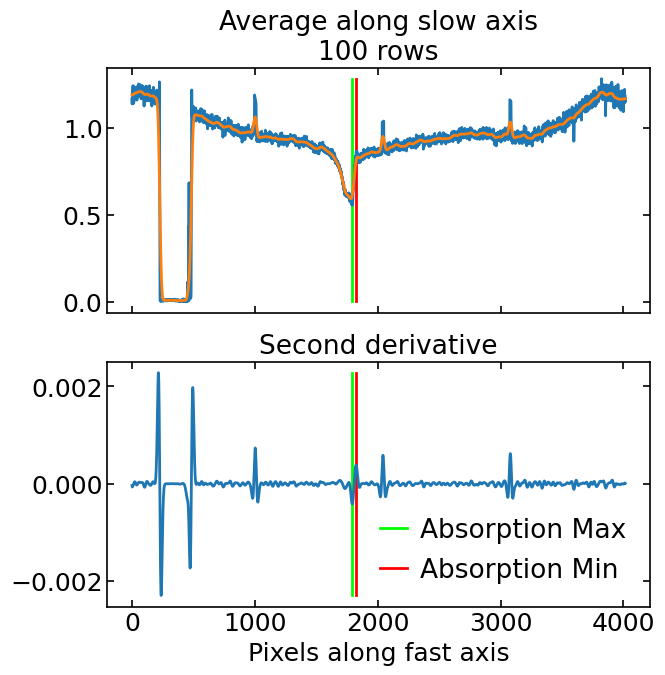

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


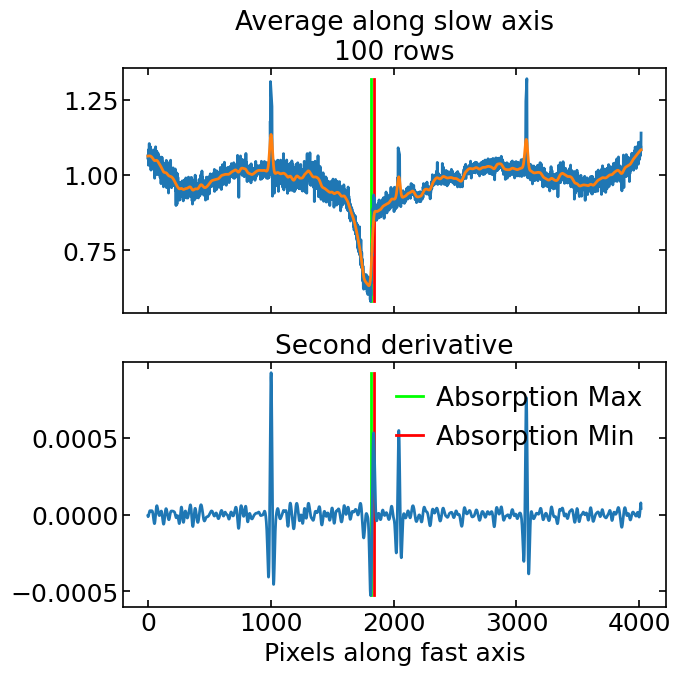

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


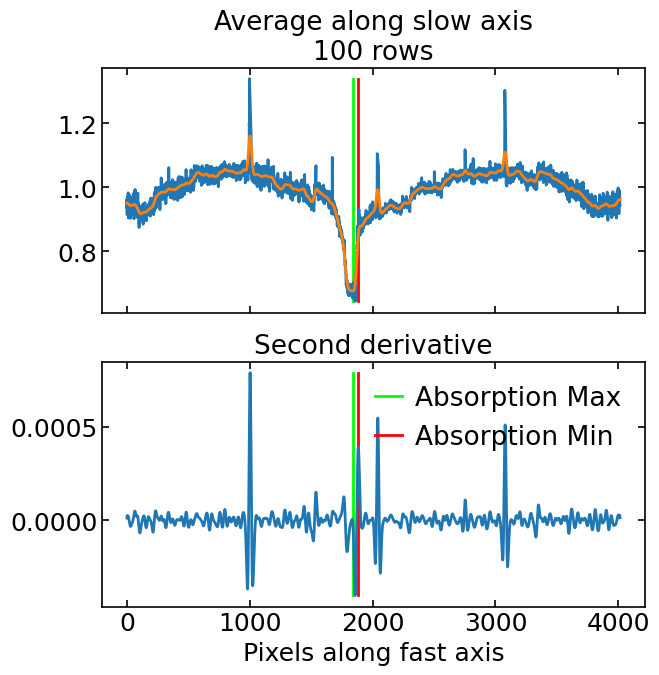

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


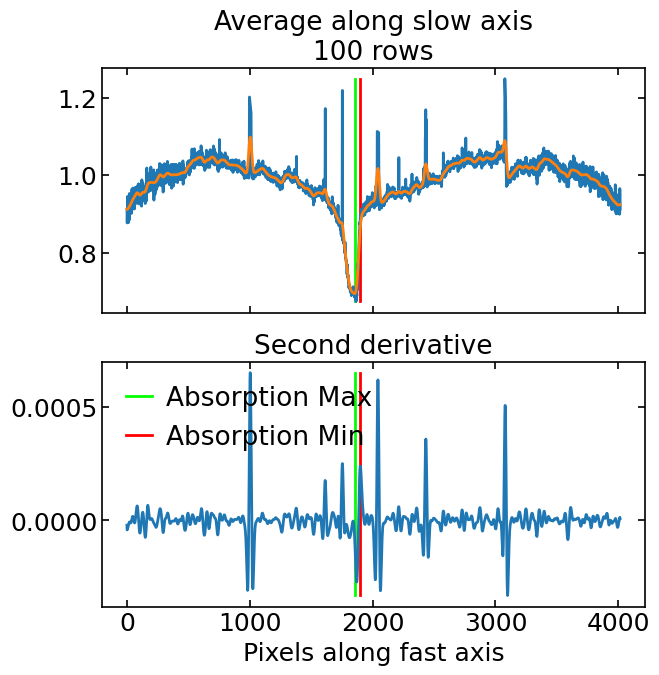

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


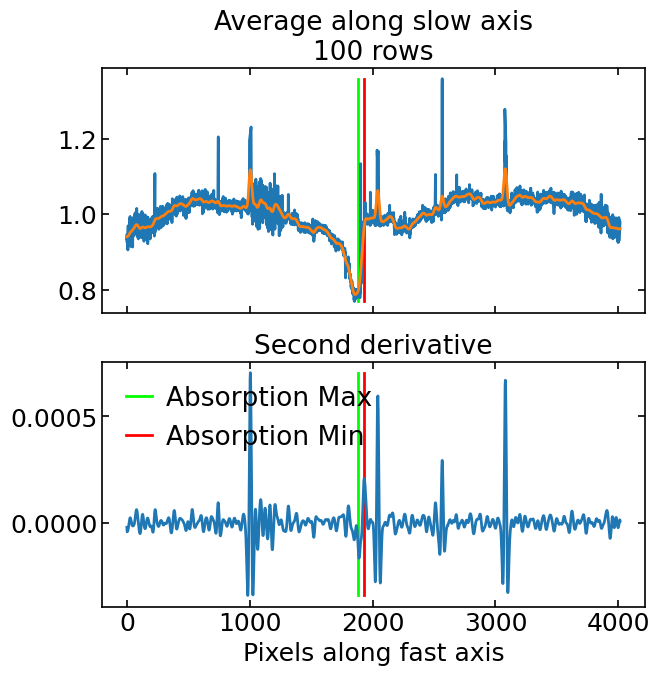

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


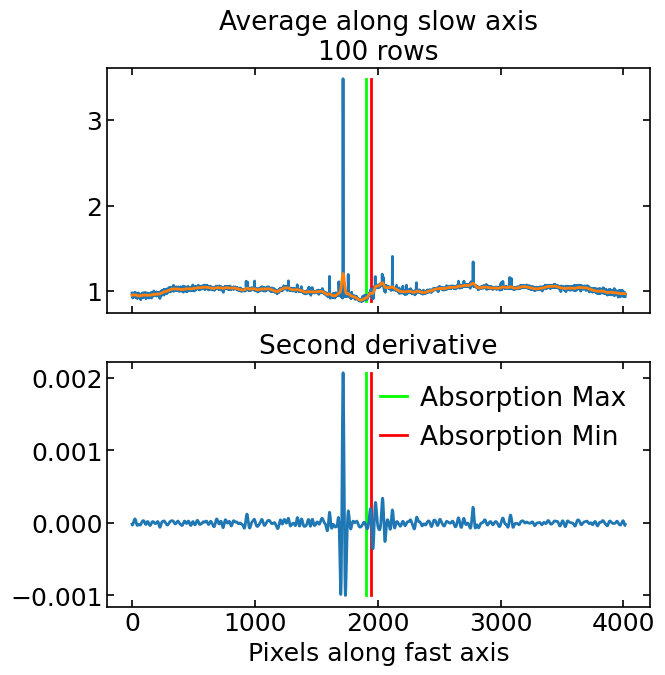

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


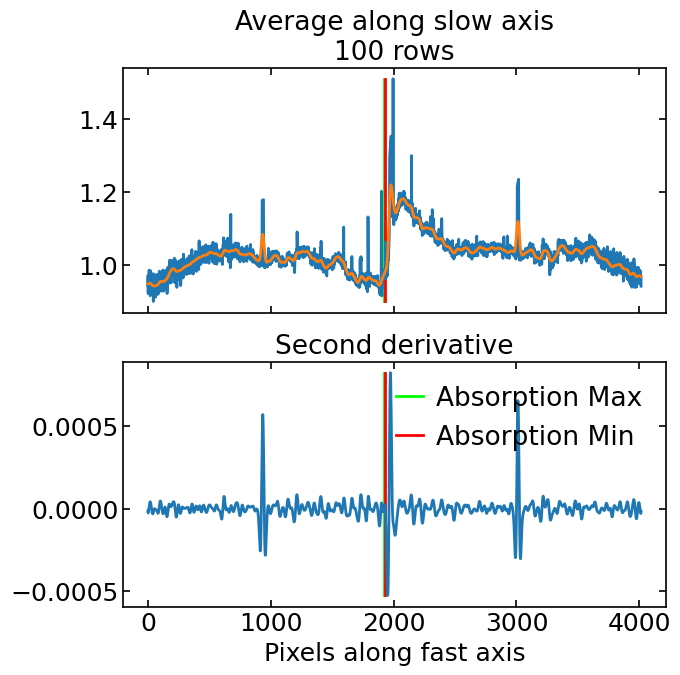

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


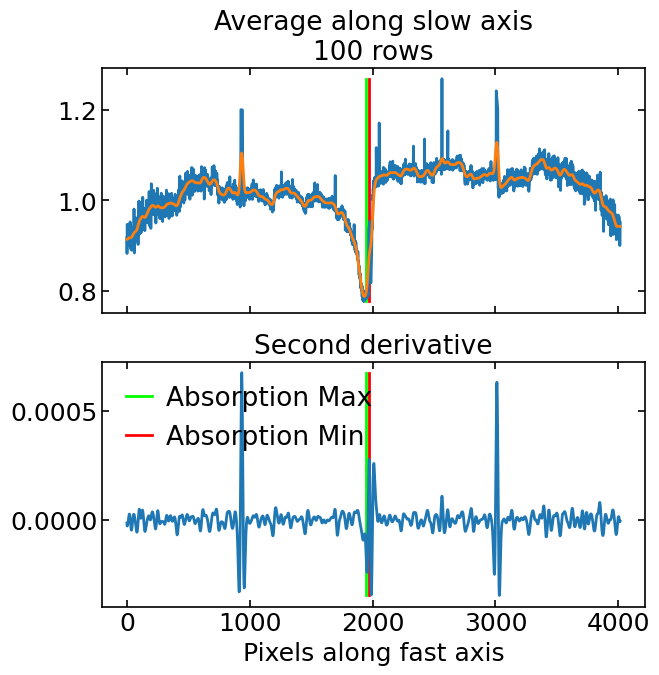

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


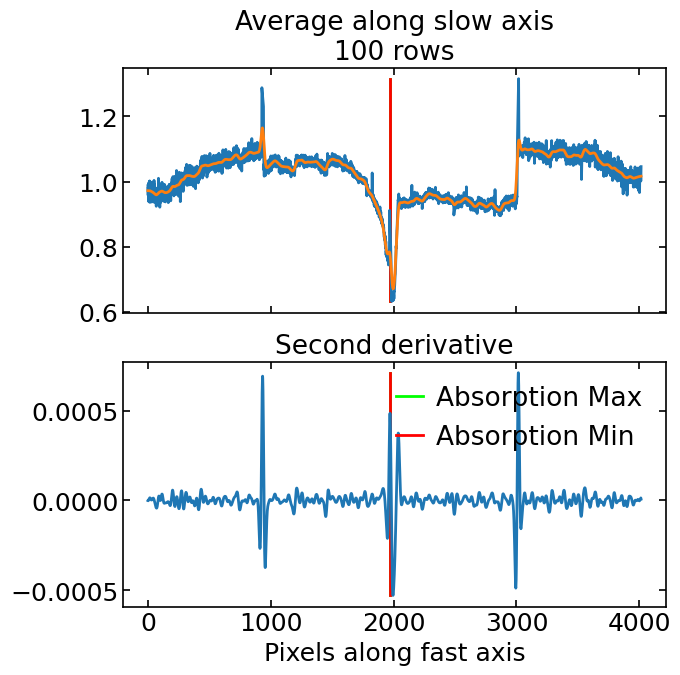

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


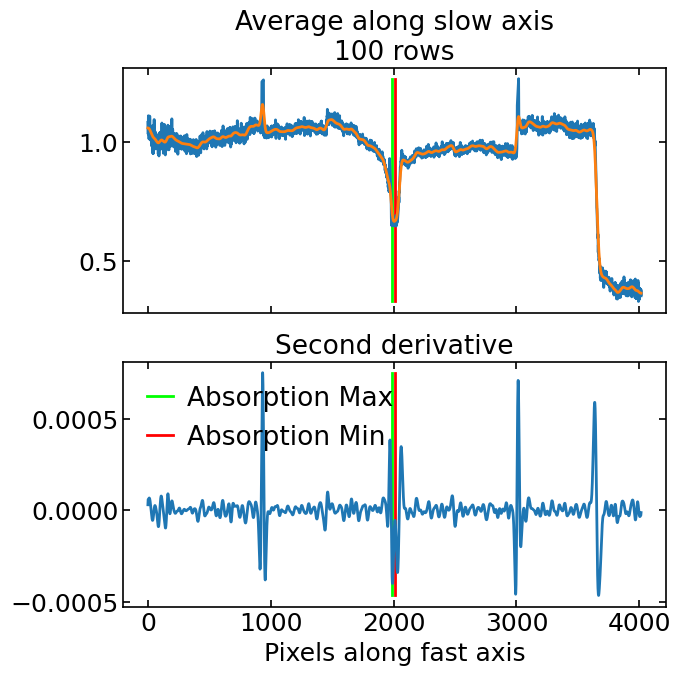

/tmp/ipykernel_221468/2303564738.py:47: RuntimeWarning: Mean of empty slice
  curve = np.nanmean(normalized_image[rows * index: rows * (index+1), sides: -sides], axis=0)


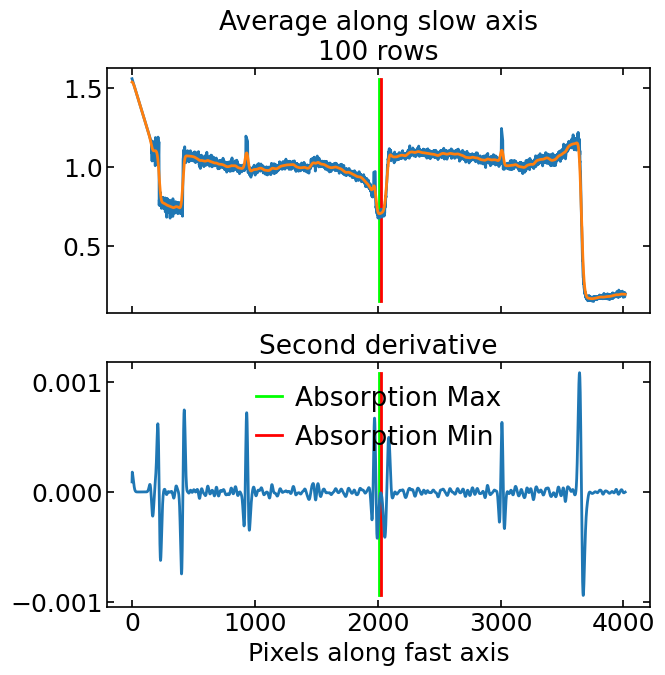

[[1896.  200.]
 [1911.  600.]
 [1957. 1000.]
 [1965. 1400.]
 [1952. 1800.]
 [2029. 3000.]
 [2098. 3400.]
 [2096. 3800.]
 [2104. 4200.]]


In [136]:
p_max_abs, p_min_abs, xy_max, xy_min = FindMaxAbs(normalized_image, mask)
print(xy_max)


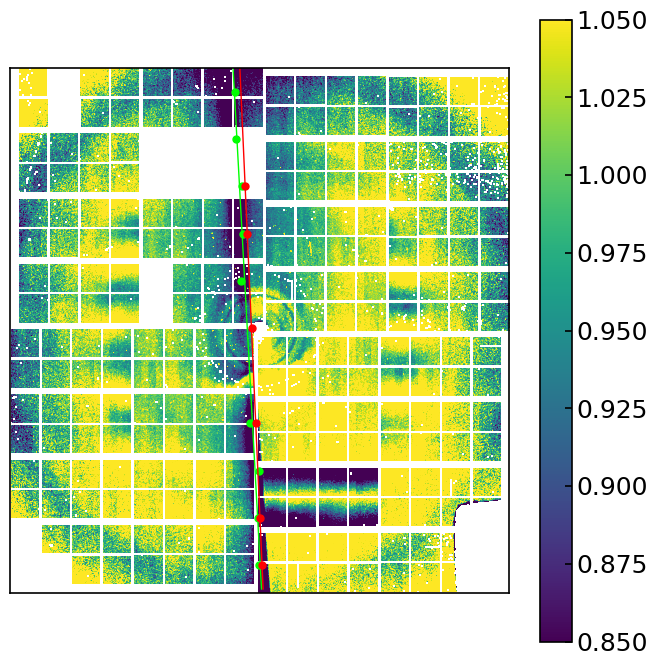

In [137]:
y = np.array([0, 4400])
x_max = y*p_max_abs[0] + p_max_abs[1]
x_min = y*p_min_abs[0] + p_min_abs[1]

fig, axes = plt.subplots(1, 1)
im = axes.imshow(normalized_image, vmin=0.85, vmax=1.05)
axes.plot(xy_max[:, 0], xy_max[:, 1], linestyle='none', marker='.', color=[0, 1, 0])
axes.plot(x_max, y, color=[0, 1, 0], linewidth=1)
axes.plot(xy_min[:, 0], xy_min[:, 1], linestyle='none', marker='.', color=[1, 0, 0])
axes.plot(x_min, y, color=[1, 0, 0], linewidth=1)
axes.set_xticks([])
axes.set_yticks([])
fig.colorbar(im, ax=axes)
fig.tight_layout()
plt.show()